# Comparing Portland Census Tracts Using Population and Reported Crimes

**Author:**
*Travis Hathaway*

### Summary
The goal of this notebook is to setup all of the data necessary to feed an online map using OpenLayers. We will walk through the process of importing various data sources in PostgreSQL, process this data, and then generate a series of GeoJSON files that our OpenLayers application can consume.

### Data Sources

- **Crime Reports Data:** ftp://ftp02.portlandoregon.gov/CivicApps/
- **2010 Census Tracts:** http://navigator.state.or.us/sdl/data/2010census/tracts2010.zip

### Requirements for running

- Local instance of PostgreSQL with the PostGIS extension enabled
- The following Python Libraries:
    - psycopg
- [ogr2ogr](http://www.gdal.org/index.html)
- shp2pgsql
- [csvsql](https://csvkit.readthedocs.io/en/1.0.1/)

In [2]:
import psycopg2
import pandas as pd
%matplotlib inline 

def get_conn():
    conn_data = {
        'database': 'crimestats2',
        'user': 'travishathaway',
        'host': 'localhost',
        'password': ''
    }

    return psycopg2.connect(**conn_data)

In [5]:
conn = get_conn()
cur = conn.cursor()

### Step One: Importing our data to Postgres

**Crime Reports Data:**

For this data, I have written a bash script that does the following:

- Retrieves the data from the FTP server where it is stored
- Creates the tables in Postgres to store the data in
- Loads the data

**[You can view the script here](https://gist.github.com/travishathaway/1e6ffd0544ca7803f0e0ae4c630aaccf)**

**2010 Census Tract Data**

To load the census data in to database, we simply run the shp2pgsql command. We know that the SRID for this shapefile is 2992, so we make sure to set it when loading the data in.

```bash
shp2pgsql -I -s 2992 Tracts_PL.shp public.or_census_tracts_2010 | psql crimestats2
```

### Step Two: Adding a geom field to our crime reports table

In order to make performing spacial queries easier, we must first add a geom field to the our crime reports table. We will create this geom as a POINT geometry and then use the existing `x_coordinate` and `y_coordinate` fields to populate the new field. During this alter of the crime reports table, we will also reproject the points to the same projection used on the census tracts table, SRID 2992.

In [4]:
add_geom_field_sql = "SELECT AddGeometryColumn ('public','portland_crime_stats','geom',2992,'POINT',2)"
cur.execute(add_geom_field_sql)
conn.commit()

In [7]:
set_geom_sql = """
    UPDATE portland_crime_stats
    SET geom = ST_Transform(ST_SetSRID(ST_Point(x_coordinate, y_coordinate),2913), 2992)
"""
cur.execute(set_geom_sql)
conn.commit()

### Step Three: Create a table that will store our crime counts and fill it with data

Now we will be counting the number of crimes in each census block by year.  This calculation is a lengthy process, so calculating it each time we need to retrieve this data would not be wise. Instead, we will run the calculation once, and store the results in a table that can later be joined to our census tracts table.

Unfortunately, our current crime reports table has entries without location data:

In [10]:
cur.execute('SELECT count(*) FROM portland_crime_stats WHERE geom IS NULL')
print(cur.fetchone()[0])

90067


To make the spacial join just a little less taxing, we are going to create new table comprised only of rows where the `geom` field is not null

In [12]:
cur.execute("""
    SELECT * INTO portland_crime_stats_with_geom 
    FROM portland_crime_stats 
    WHERE geom IS NOT NULL
""")
conn.commit()

Now we have this many rows:

In [14]:
cur.execute('SELECT count(*) FROM portland_crime_stats_with_geom')
print(cur.fetchone()[0])

649349


Our census tract table also suffers from the same problem as our crime reports table.  Right now, that table has census tracts from all over Oregon. To make our spacial join just a little more efficient, we will create a new table containing only census tracts from the "Tri-County" area.

In [15]:
cur.execute("""
    SELECT * INTO tri_county_census_tracts 
    FROM or_census_tracts_2010 
    WHERE cnty_name IN ('Multnomah', 'Washington', 'Clackamas')
""")
conn.commit()

We can now see that we have made a significant reduction in the amount of joins we will be making with our spatial query.

In [16]:
cur.execute('SELECT count(*) FROM or_census_tracts_2010')
all_tracts = cur.fetchone()[0]

cur.execute('SELECT count(*) FROM tri_county_census_tracts')
tri_county_tracts = cur.fetchone()[0]

print("All Tracts in Oregon: {}".format(all_tracts))
print("Tri-County Tracts: {}".format(tri_county_tracts))

All Tracts in Oregon: 834
Tri-County Tracts: 355


With all of that out of the way, we are now finally ready to make our big spatial query.  This query will join the `portland_crime_stats_with_geom` table and the `tri_county_census_tracts` tables and insert the results in to a new table called `crime_reports_by_census_tract`.

Because this query takes a long time to run, I advise against running it in a Jupyter Notebook. Please copy and paste this query, and run it in pgAdmin or psql if you are following along


```sql
    SELECT
        c.geoid10, p.major_offense_type,
        extract(year from p.report_date) as year,
        count(*) as report_count
    INTO
        crime_reports_by_census_tract
    FROM
        tri_county_census_tracts c
    RIGHT JOIN
        portland_crime_stats_with_geom p
    ON
        ST_Intersects(c.geom, p.geom)
    GROUP BY
        c.geoid10, p.major_offense_type, extract(year from p.report_date)
```

Let's take a peak at what we have now:

In [18]:
df = pd.read_sql("SELECT * FROM crime_reports_by_census_tract", conn)

In [19]:
df.head()

,geoid10,major_offense_type,year,report_count
0,41005020100,Burglary,2011.0,1
1,41005020100,Larceny,2006.0,1
2,41005020200,"Assault, Simple",2013.0,1
3,41005020200,Forgery,2012.0,2
4,41005020200,Larceny,2012.0,2


As you can see, we have broken down the data set by census tract (geoid10) offense type and year. We now have a corresponding count that we can use to create a choropleth map using OpenLayers, and a means by which we can make comparisions among census tracts.

### Step Four: Create our GeoJSON files
Now we need to convert our data in to something OpenLayers can consume. For this, we will use the GeoJSON format.

To perform this, we will be using the `ogr2ogr` program.  The following bash script will generate a GeoJSON file for each year in our dataset.

```bash

for year in $(echo 200{4..9} 201{0..4})
do 
    query="SELECT
        c.geoid10, c.year, t.pop10, ST_Simplify(ST_Transform(t.geom, 4326), 0.001), 
        t.cnty_name, ST_Area(geom) / 5280^2 as sq_miles,
        sum(c.report_count) as report_count
    FROM 
        crime_reports_by_census_tract c
    LEFT JOIN
        tri_county_census_tracts t
    ON
        c.geoid10 = t.geoid10
    WHERE
        c.year = $year
    GROUP BY
        c.geoid10, c.year, t.pop10, t.geom, t.cnty_name, ST_Area(geom) / 5280^2"

    ogr2ogr -f GeoJSON census_tracts_$year.json 'PG:host=localhost dbname=crimestats2 user=travishathaway ' -sql $query
done

```

### Step Five: Finding a classification for our choropleth map

In order to find nice breaks for choropleth colors, we will have to take a look at how this data is distributed. Luckily, Pandas makes this relatively easy to do.

Here, we run the same query we used to generate the GeoJSON files, but we exclude the `geom` column. We will pick a single year, 2004, to get a good feel for how this data is distributed.

In [6]:
area_pop_and_report_sql = """
    SELECT
        c.geoid10, c.year, t.pop10, t.cnty_name, ST_Area(geom) / 5280^2 as sq_miles,
        sum(c.report_count) as report_count
    FROM 
        crime_reports_by_census_tract c
    LEFT JOIN
        tri_county_census_tracts t
    ON
        c.geoid10 = t.geoid10
    GROUP BY
        c.geoid10, c.year, t.pop10, t.geom, t.cnty_name, ST_Area(geom) / 5280^2 
"""

df = pd.read_sql(area_pop_and_report_sql, conn)

We need to add `report_density` to our data frame. This is the number reports for a census tract divided by the total area of that census tract.

In [9]:
df['report_density'] = df['report_count'] / df['sq_miles']
df['report_over_pop'] = df['report_count'] / df['pop10']

We need to filter this result a little further due to some outliers

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10fc80a58>]], dtype=object)

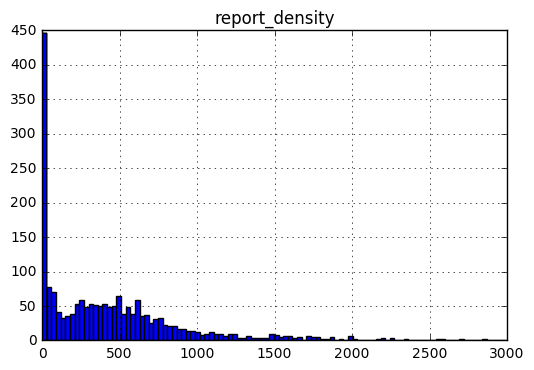

In [14]:
df[df['report_density'] < 3000].hist('report_density', bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10fdb99b0>]], dtype=object)

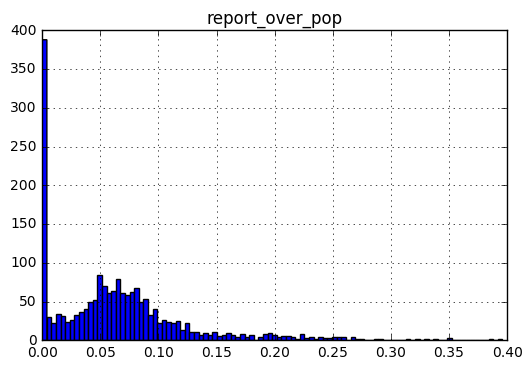

In [15]:
df[df['report_over_pop'] < 0.4].hist('report_over_pop', bins=100)

### Map Legend
Here is the choropleth color scale I chose for report densisty

<img src="./images/map_legend.png" alt="map legend" />

### Finished Product

Visit **[https://crimestats.travishathaway.com/#/map](https://crimestats.travishathaway.com/#/map)** to see the finished product.